In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.feature_selection import SelectKBest, chi2
% matplotlib inline
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

churn = pd.read_excel('/Users/Kadibhai/Downloads/WA_Fn-UseC_-Telco-Customer-Churn.xlsx',sheet_name=None)
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [2]:
churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


,SeniorCitizen,tenure,MonthlyCharges
SeniorCitizen,1.000000,0.016567,0.220173
tenure,0.016567,1.000000,0.247900
MonthlyCharges,0.220173,0.247900,1.000000


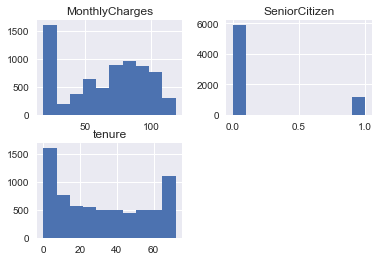

In [3]:
churn.hist()
churn.corr()

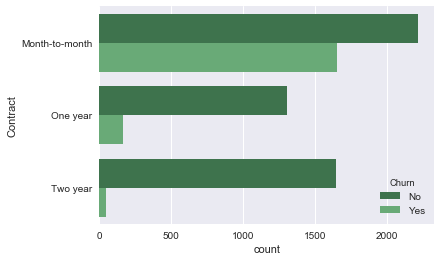

In [4]:
sns.countplot(y="Contract", hue="Churn", data=churn, palette="Greens_d")
plt.show()

In [43]:
churn["TotalCharges"] = pd.to_numeric(churn["TotalCharges"],errors='coerce',downcast='float')
churn.replace(["NaN", 'NaT'], np.nan, inplace = True)

churn = churn.dropna()

## check for balance 
churn['Churn'].value_counts()

No     5163
Yes    1869
Name: Churn, dtype: int64

In [95]:
y = churn['Churn']
y = y.replace(['Yes','No'],[1,0])

cat_vars = pd.get_dummies(churn.select_dtypes(include=['object']).drop(['Churn','customerID'],axis=1),drop_first=True)

num_vars = churn.select_dtypes(include=['float64','float32','int64'])

X = pd.concat((cat_vars,num_vars),axis=1)


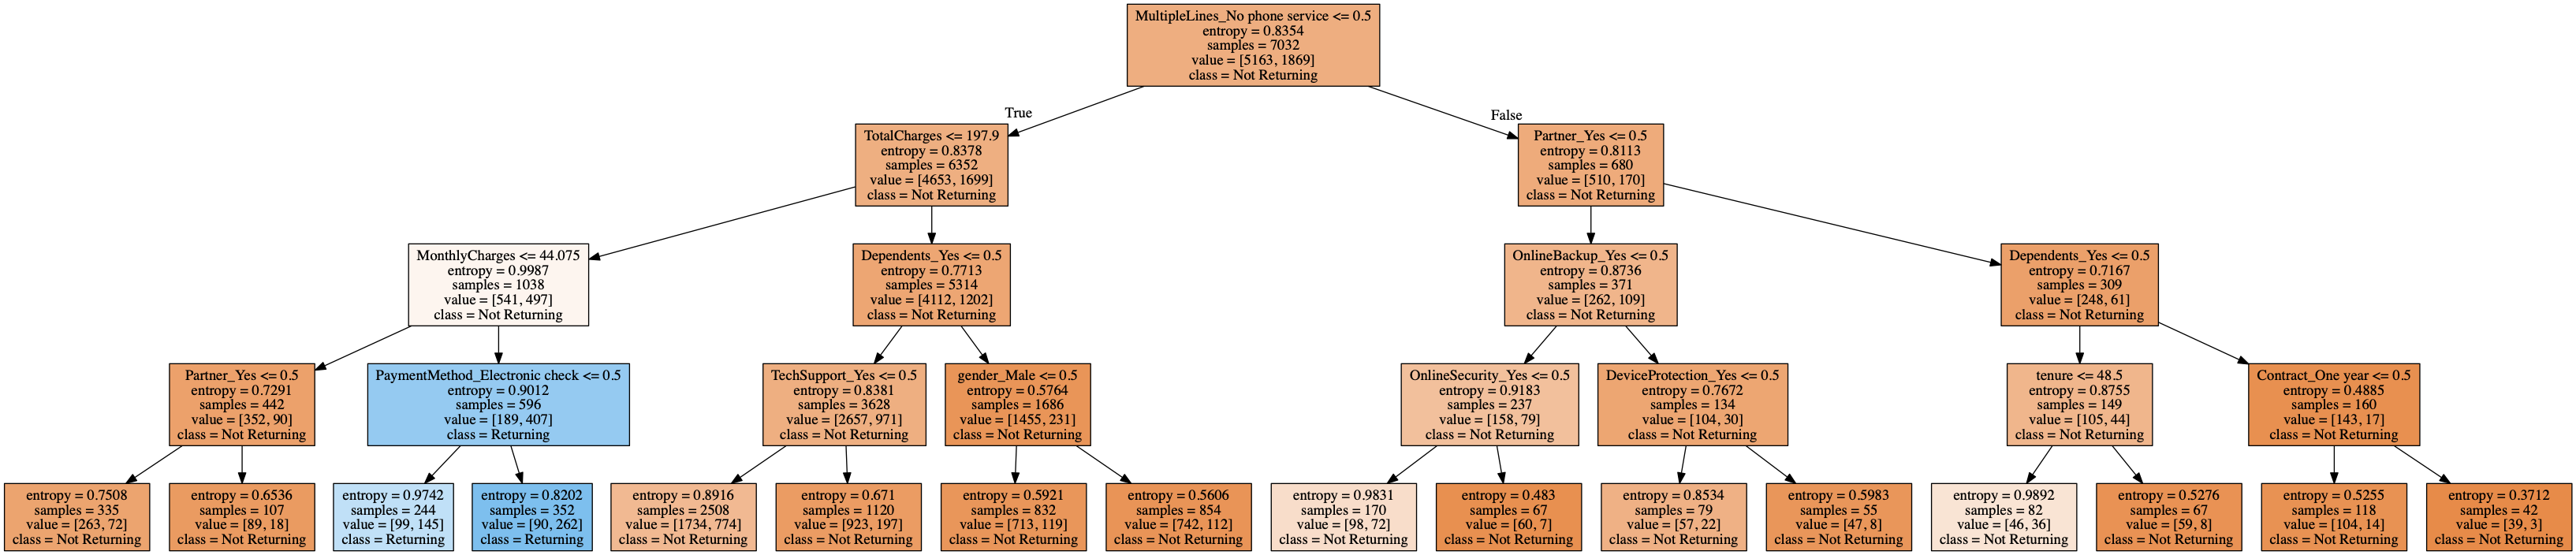

In [96]:
from sklearn import tree

# A convenience for displaying visualizations.
from IPython.display import Image

# Packages for rendering our tree.
import pydotplus
import graphviz

# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=4,
    random_state = 1337
)
decision_tree.fit(X,y)

# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
    class_names=['Not Returning', 'Returning'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [98]:
cross_val_score(decision_tree, X, y, cv=10).mean()

0.7626591338762392

In [63]:
X_new = SelectKBest(chi2, k=20).fit_transform(X,y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

rfc = ensemble.RandomForestClassifier()

param_grid = {
    'bootstrap': [True],
    'max_depth': [2,4,6],
    'max_features': [none,2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [10, 20, 30]
}

grid_search = GridSearchCV(rfc, param_grid, cv=5,
 scoring='accuracy')

grid_search.fit(X_train, y_train)

final_model = grid_search.best_estimator_

In [36]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(final_model, X_train, y_train, cv=10)

print(classification_report(y_train, y_train_pred))

             precision    recall  f1-score   support

          0       0.80      0.92      0.86      4130
          1       0.62      0.34      0.44      1495

avg / total       0.75      0.77      0.75      5625



In [42]:
from sklearn.metrics import accuracy_score

y_pred = final_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.7718550106609808

In [29]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()

log_reg.fit(X_train, y_train)

y_train_pred = cross_val_predict(log_reg, X_train, y_train, cv=10)

print(classification_report(y_train, y_train_pred))

             precision    recall  f1-score   support

          0       0.85      0.90      0.87      4130
          1       0.66      0.55      0.60      1495

avg / total       0.80      0.80      0.80      5625



In [35]:
from sklearn.metrics import accuracy_score

y_pred = log_reg.predict(X_test)
accuracy_score(y_test, y_pred)

0.7945984363894811

In [32]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [2,3, 4, 5]}]

grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3, n_jobs=-1)

grid_search.fit(X_train, y_train)

final_model = grid_search.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] n_neighbors=2, weights=uniform ..................................
[CV] n_neighbors=2, weights=uniform ..................................
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ... n_neighbors=2, weights=uniform, score=0.764444, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ... n_neighbors=2, weights=uniform, score=0.761778, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] n_neighbors=2, weights=distance .................................
[CV] ... n_neighbors=2, weights=uniform, score=0.760889, total=   0.0s
[CV] n_neighbors=2, weights=distance .................................
[CV] ... n_neighbors=2, weights=uniform, score=0.759111, total=   0.1s
[CV] ... n_neighbors=2, weights=uniform, score=0.760889, total=   0.1s
[CV] n_neighbors=2, weights=distance .................................
[CV] n_neighbors=

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.8s finished


In [33]:
y_train_pred = cross_val_predict(final_model, X_train, y_train, cv=10)

print(classification_report(y_train, y_train_pred))

             precision    recall  f1-score   support

          0       0.80      0.92      0.86      4130
          1       0.62      0.34      0.44      1495

avg / total       0.75      0.77      0.75      5625



In [34]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.7718550106609808

In [92]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = StandardScaler().fit_transform(X)

pca = PCA(n_components=4)
principalComponents = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3','principal component 4'])

pca.explained_variance_ratio_

array([0.55204257, 0.2638417 , 0.16930797, 0.01480776])

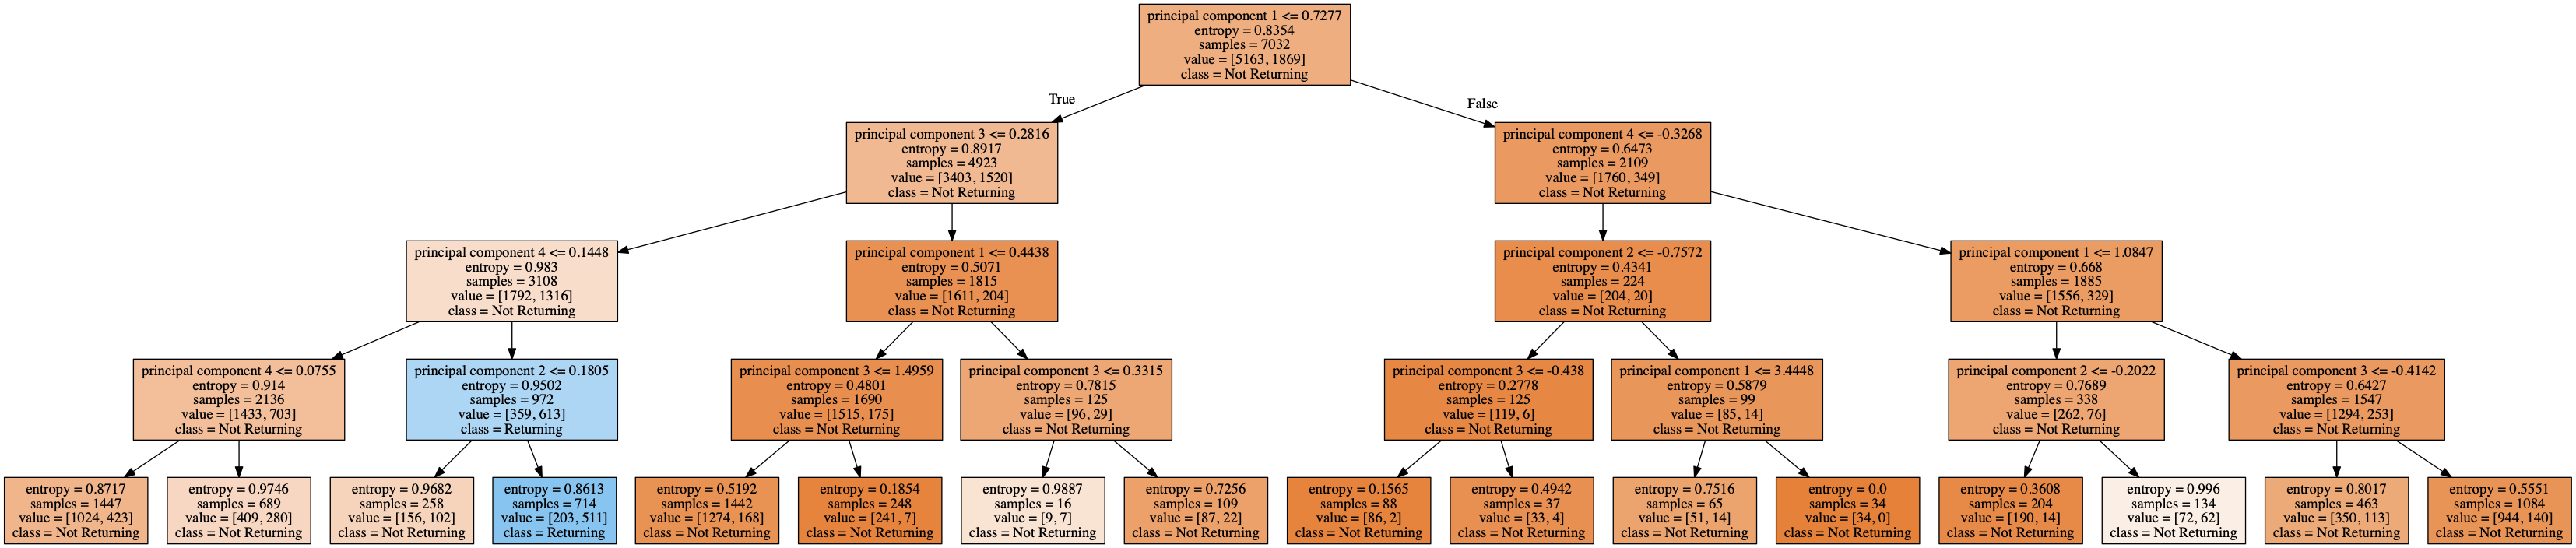

In [100]:
# A convenience for displaying visualizations.
from IPython.display import Image

# Packages for rendering our tree.
import pydotplus
import graphviz

# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=4,
    random_state = 1337
)
decision_tree.fit(principalDf,y)

# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=principalDf.columns,
    class_names=['Not Returning', 'Returning'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [101]:
cross_val_score(decision_tree, principalDf, y, cv=10).mean()

0.7744543534839587